## Описание проекта <a id='section0.1'></a>

В нашем распоряжении исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


### Описание данных <a id='section0.2'></a>

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

### Содержание

#####  Общие данные:
* [1. Описание проекта](#section0.1)
* [2. Описание данных](#section0.2)
* [3. Загрузка библиотек](#section0.3)
* [4. Загрузка данных](#section0.4)
* [5. Используемые функции](#section0.5)

##### Часть 1. Подготовка данных:
* [1. Подготовка данных](#section1.1)


##### Часть 2. Анализ:
* [2.1. Анализ](#section2.1)
* [2.2. SARIMAX](#section2.2)
* [3. LinearRegression](#section2.3)

##### Часть 3. Обучение моделей:
* [3. Обучение моделей](#section3)

##### Часть 4. Тестирование:
* [4.1. SARIMAX](#section4.1)
* [4.1. LinearRegression](#section4.2)
* [4.2.1. Улучшим линейную модель и сделаем прогноз](#section4.2.1)

## Импортируем библиотеки <a id='section0.3'></a>

In [1]:
# Импортируем библиотеки
# для работы с данными
import pandas as pd
import numpy as np
from itertools import product
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose

# для работы с датой
from datetime import datetime, timedelta

#Предупреждения
import warnings
warnings.filterwarnings('ignore')

#для загрузки данных
from pathlib import Path
import os
import urllib.request

# Для Графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#для построения моделей
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, LassoCV


from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit



#Для фиксации времени
from timeit import default_timer as timer

#Для визуализации процесса
from tqdm.notebook import tqdm

## Загрузим данные <a id='section0.4'></a>

In [2]:
#Cоздадим папку если ее нет
Path('datasets').mkdir(parents=True, exist_ok=True)

#словарь с именем файла и ссылкой на него
urls = {
    'taxi': ('/datasets/taxi.csv', '.../datasets/taxi.csv')
}

def get_file(file_name, url):
    #Проверим есть ли файл
    if not os.path.exists(file_name):
        print(file_name, 'файл не найден, будет загружен из сети')
        #качаем файл по ссылке url, кладем по пути file_name
        _ = urllib.request.urlretrieve(url, file_name)

[get_file(*urls[k]) for k in urls]
     
data = pd.read_csv(urls['taxi'][0], index_col=['datetime'], parse_dates=['datetime'], dayfirst=False)

## Используемые функции  <a id='section0.3'></a>

In [3]:
def simple_plot(series, series2=None, ylabel=None,
                title=None, series1_label=None, series2_label=None,
                fontsize=14, figsize=(15, 7),
                sec_series=False, legeng=False, style='bmh'):
    
    with plt.style.context(style):
        plt.figure(figsize=figsize)

        if legeng:
            plt.plot(series, label=series1_label)
            if sec_series:
                plt.plot(series2, label=series2_label)

        if not legeng:
            plt.plot(series)
            if sec_series:
                plt.plot(series2)        

        if legeng:
            plt.legend(loc='best')
        plt.title(title, fontsize=fontsize)
        plt.grid(True)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()

In [4]:
def invboxcox(y, lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [5]:
def tsplot(y, lags=48, style='bmh', figsize=(13, 7)):
    
    """
    Построение графика временного ряда и его автокорреляции
    """
    
    with plt.style.context(style):
        fig    = plt.figure(figsize=figsize)
        layout = (2, 2)

        ts_ax   = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax  = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.adfuller(y)[1]
        ts_ax.set_title('График временного ряда\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        
        sm.graphics.tsa.plot_acf(y.values.squeeze(), lags=lags, ax=acf_ax)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [6]:
def prepareData(data, lag_start=1, lag_end=2, test_size=0.1):
    
    """
    data - 1-D массив, временной ряд
    """
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    
    #data.index = data.index.to_datetime()
    data["hour"]       = data.index.hour
    data["weekday"]    = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = data.weekday.map(dict(data[ : test_index].groupby('weekday')['y'].mean()))
    data["hour_average"]    = data.hour.map(dict(data[ : test_index].groupby('hour')['y'].mean()))
    
    
    data['sum_for_last_3h']  = data['y'].shift().rolling(3).sum()
    data['sum_for_last_12h'] = data['y'].shift().rolling(12).sum()
    data['sum_for_last_8h']  = data['y'].shift().rolling(8).sum()
    data['sum_WTD']          = data['y'].shift().rolling(24*7).sum()
    

    # выкидываем закодированные средними признаки 
    #data.drop(["hour", "weekday"], axis=1, inplace=True)
    
#     cat_features = ['hour', 'is_weekend', 'weekday']
    
    data = data.dropna()
    data = data.reset_index(drop=True)
#     data[cat_features] = data[cat_features].astype('category')
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

In [7]:
def plotLinReg_result(model, X_test, y_test, plot_inervals=False, plot_anomalies=False,
                      interval_of_interest=24*3, scaler=1.96, style='bmh',
                      figsize=(15, 7)
                     ):
    
    """
    model - модель линейной регрессии
    X_test, y_test - тестовые выборки
    """
    
    y_test    = pd.DataFrame(y_test, columns=['y'])
    model_mse = mean_squared_error(y_test, model.predict(X_test))
    pred      = pd.DataFrame(model.predict(X_test), index=y_test.index)
    rmse      = np.sqrt(mean_squared_error(y_test, pred))
    
    with plt.style.context(style):
                
        plt.figure(figsize=figsize)
        plt.plot(pred[-interval_of_interest:], label='model')
        plt.plot(y_test[-interval_of_interest:], label='actual')
        
        if plot_anomalies:
            
            lower_bound = pred - np.sqrt(model_mse)*scaler
            lower_bound = pd.DataFrame(lower_bound, index=y_test.index)
            lower_bound.columns = ['lower_bound']

            upper_bound = pred + np.sqrt(model_mse)*scaler
            upper_bound = pd.DataFrame(upper_bound, index=y_test.index)
            upper_bound.columns = ['upper_bound']
            
            anomalies = y_test.join(lower_bound).join(upper_bound)
            anomalies['alarm'] = anomalies.loc[(anomalies.y < anomalies.lower_bound) |
                                               (anomalies.y > anomalies.upper_bound),
                                               y_test.columns
                                              ]

            plt.plot(anomalies.alarm[-interval_of_interest:], "ro", markersize=7, label='Аномалии')
            plt.fill_between(x=y_test[-interval_of_interest:].index,
                             y1=list(upper_bound[-interval_of_interest:].upper_bound),
                             y2=list(lower_bound[-interval_of_interest:].lower_bound), 
                             alpha=0.2, color = "grey"
                            )
            
        if plot_inervals:
            if not plot_anomalies:
                lower_bound = pred - np.sqrt(model_mse)*scaler
                lower_bound = pd.DataFrame(lower_bound, index=y_test.index)
                lower_bound.columns = ['lower_bound']

                upper_bound = pred + np.sqrt(model_mse)*scaler
                upper_bound = pd.DataFrame(upper_bound, index=y_test.index)
                upper_bound.columns = ['upper_bound']

            plt.plot(lower_bound[-interval_of_interest:], 'r--', alpha=0.4, label='Upper/Lower bounds')
            plt.plot(upper_bound[-interval_of_interest:], 'r--', alpha=0.4)
            
        plt.title('Предсказание модели\n RMSE = {:0.2f}\n'.format(rmse) )
        plt.legend()
        plt.grid(True)

In [8]:
def plotSARIXA_result(pred, y_true, lmbda, forecast,
                      plot_forecast=False, plot_inervals=False, plot_anomalies=False,
                      interval_of_interest=24*3, forecast_int=24*3, scaler=1.96, style='bmh',
                      model_mse=13.6658, figsize=(15, 7)
                     ):
    
    """
    pred - предсказание модели SARIMAX
    y_true - действительные значения
    lmbda - коэффициента обратного преобразования Бокса-Кокса
    forecast - предсказание модели SARIMAX
    """
    y_true = pd.DataFrame(y_true)    
    
    rmse = np.sqrt(mean_squared_error(y_true, invboxcox(pred, lmbda)))
    
    with plt.style.context(style):
                
        plt.figure(figsize=figsize)
        plt.plot(invboxcox(pred[-interval_of_interest:], lmbda), label='model')
        plt.plot(y_true[-interval_of_interest:], label='actual')
        
        if plot_forecast:

            plt.plot(invboxcox(forecast[y_true.index[-1]: ], lmbda), label='Forecast')
            
            forecast_lower_bound = invboxcox(forecast - np.sqrt(model_mse)*scaler, lmbda)
            forecast_upper_bound = invboxcox(forecast + np.sqrt(model_mse)*scaler, lmbda)
            
            plt.plot(forecast_lower_bound[y_true.index[-1]: ], 'g--', label="Forecast Upper/Lower bounds")
            plt.plot(forecast_upper_bound[y_true.index[-1]: ], 'g--')
            plt.fill_between(x=forecast[y_true.index[-1]: ].index, 
                             y1=list(forecast_lower_bound[y_true.index[-1]: ]),
                             y2=list(forecast_upper_bound[y_true.index[-1]: ]),
                             alpha=0.2, color = "blue")

            plt.axvspan(y_true.index[-1], forecast.index[-1], alpha=0.3,color='lightblue')
            plt.text(x=forecast.index[-int(len(forecast[y_true.index[-1]: ])/2)],
                     y=forecast_upper_bound[y_true.index[-1]: ].max()+10, s='Forecast'
                    )
            plt.text(x=y_true.index[-int(len(y_true[-interval_of_interest:])/2)],
                     y=y_true[-interval_of_interest: ].max()+10,
                     s='Actual'
                    )
        if plot_anomalies:
            
            lower_bound = invboxcox(pred - np.sqrt(model_mse)*scaler, lmbda)
            lower_bound = pd.DataFrame(lower_bound)
            lower_bound.columns = ['lower_bound']

            upper_bound = invboxcox(pred + np.sqrt(model_mse)*scaler, lmbda)
            upper_bound = pd.DataFrame(upper_bound)
            upper_bound.columns = ['upper_bound']
            
            anomalies = y_true.join(lower_bound).join(upper_bound)
            anomalies['alarm'] = anomalies.loc[(anomalies.num_orders < anomalies.lower_bound) |
                                           (anomalies.num_orders > anomalies.upper_bound),
                                           y_true.columns
                                          ]

            plt.plot(anomalies.alarm[-interval_of_interest:], "ro", markersize=7, label='Аномалии')
            plt.fill_between(x=y_true[-interval_of_interest:].index, 
                         y1=list(upper_bound[-interval_of_interest:].upper_bound),
                         y2=list(lower_bound[-interval_of_interest:].lower_bound), 
                         alpha=0.2, color = "grey")
            
        if plot_inervals:
            
            lower_bound = invboxcox(pred - np.sqrt(model_mse)*scaler, lmbda)
            lower_bound = pd.DataFrame(lower_bound)
            lower_bound.columns = ['lower_bound']

            upper_bound = invboxcox(pred + np.sqrt(model_mse)*scaler, lmbda)
            upper_bound = pd.DataFrame(upper_bound)
            upper_bound.columns = ['upper_bound']

            plt.plot(lower_bound[-interval_of_interest:], 'r--', alpha=0.4, label='Upper/Lower bounds')
            plt.plot(upper_bound[-interval_of_interest:], 'r--', alpha=0.4)
            

        plt.title('Предсказание и прогноз модели\n RMSE = {:0.2f}\n'.format(rmse) )
        plt.legend()
        plt.grid(True)

In [9]:
def plotCoefficients(model, X_train, figsize=(13, 4)):

    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    with plt.style.context('ggplot'):    
        plt.figure(figsize=figsize)
        coefs.coef.plot(kind='bar')
        plt.grid(True, axis='y')
        plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

Функции для предсказания Линейной модели

In [10]:
def code_hour_average(data):
    return dict(data.groupby('hour')['y'].mean())

In [11]:
def make_features(data, lag_list=(24, 47, 27, 28)):
    
    """
    data - 1-D array
    
    """
    #lag_list - список наиболее значимых лагов
    lag_list=(24, 47, 27, 28)
    
    df = pd.DataFrame(data.copy())
    df.columns = ['y']
    

    df.index = pd.to_datetime(df.index)
    df["hour"] = df.index.hour
    average_hour_dict = code_hour_average(df)
    df["hour_average"] = list(map(average_hour_dict.get, df.hour))
    df["lag_{}".format(lag_list[0])] = df.y.shift(lag_list[0])
    df["lag_{}".format(lag_list[1])] = df.y.shift(lag_list[1])
    df['sum_for_last_3h']  = df['y'].shift().rolling(3).sum()
    df["lag_{}".format(lag_list[2])] = df.y.shift(lag_list[2])
    df["lag_{}".format(lag_list[3])] = df.y.shift(lag_list[3])
    df['sum_for_last_12h'] = df['y'].shift().rolling(12).sum()
    df['sum_WTD']          = df['y'].shift().rolling(24*7).sum()

    
    df.drop(columns=['hour'], inplace=True)
    df = df.dropna()
    return df, average_hour_dict

In [12]:
def create_new_rows(model, df, _dict, steps=5):
    
    cols = ['hour_average', 'lag_24', 'lag_47',
            'sum_for_last_3h', 'lag_27', 'lag_28',
            'sum_for_last_12h', 'sum_WTD']
    
    lag_list=(24, 47, 27, 28)
    
    for step in range(steps):
        
        ind = df.index[-1] + timedelta(hours=1)

        new_row = {
            'datetime': [ind],
            'y' : [int(model.predict(df[cols][-1 : ]))],
            'hour_average' : [_dict[ind.hour]],
            'lag_24' : [df['y'].iloc[-(lag_list[0])]],
            'lag_47' : [df['y'].iloc[-(lag_list[1])]],
            'sum_for_last_3h' : [df.y[-3:].sum()],
            'lag_27' : [df['y'].iloc[-(lag_list[2])]],
            'lag_28' : [df['y'].iloc[-(lag_list[3])]],
            'sum_for_last_12h' : [df.y[-12: ].sum()],
            'sum_WTD' : [df.y[-24*7: ].sum()]
        }

        row = pd.DataFrame(new_row)
        row.set_index('datetime', inplace=True)

        df = pd.concat([df, row])
        
    return df

In [13]:
def lin_model_forecast(model, data, steps):
    
    df, _dict = make_features(data)
    df = create_new_rows(model=model, df=df, steps=steps, _dict=_dict)
    
    forecast = pd.DataFrame(df.y[-steps : ])
    return forecast

In [17]:
def plot_forecast(model, data, steps=24*3, figsize=(15, 7), style='bmh', scaler=1.96):
    
    forecast = lin_model_forecast(model, data, steps)
    df, _dict = make_features(data)
    predict = model.predict(df.drop(columns='y', axis=1))
    RMSE = np.sqrt(mean_squared_error(df.y, predict))
    
    with plt.style.context(style):
                
        plt.figure(figsize=figsize)

        plt.plot(forecast.y, label='Forecast')

        forecast_lower_bound = forecast.y - RMSE*scaler
        forecast_upper_bound = forecast.y + RMSE*scaler

        plt.plot(forecast_lower_bound, 'g--', label="Forecast Upper/Lower bounds")
        plt.plot(forecast_upper_bound, 'g--')
        plt.fill_between(x=forecast.index, 
                         y1=list(forecast_lower_bound),
                         y2=list(forecast_upper_bound),
                         alpha=0.1, color = "blue")
    
    plt.ylim((0, 400))
    plt.ylabel('Число заказов')
    plt.legend()    
    plt.title('Прогноз количества заказов на {} часов'.format(steps))


# 1. Подготовка <a id='section1.1'></a>

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [15]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [16]:
if data.index.is_monotonic:
    print('Данные упорядочены по времени')

Данные упорядочены по времени


Посмотрим на графики

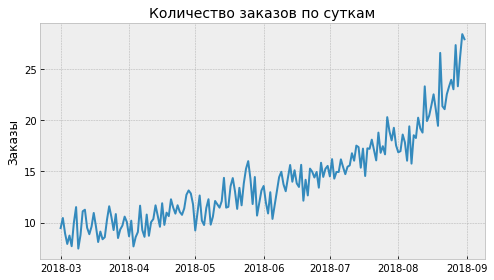

In [21]:
simple_plot(data.resample('1D').mean(), title='Количество заказов по суткам', figsize=(7,4),
            ylabel='Заказы')

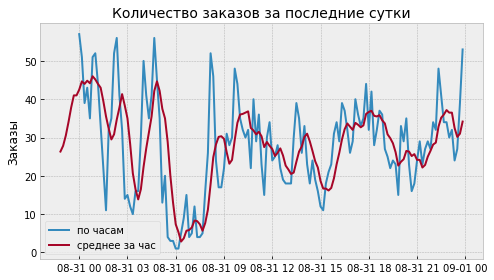

In [22]:
simple_plot(series=data[int(-6*24):],
            series2=data[int(-6*26):].rolling(6).mean(),
            title='Количество заказов за последние сутки', ylabel='Заказы',
            series1_label='по часам', series2_label='среднее за час',
            sec_series=True, figsize=(7,4), legeng=True
           )

## Вывод

1. В данных наблюдается уверенный тренд
2. Тредн имеет близкую к линейной зависимости, поэтому дополнительных фитч со "степенной зависимостью" добавлять не будем
3. В данных наблюдается сезонностьпричем как внутри дня, так и внутри недели

# 2. Анализ <a id='section2.1'></a>

Далее будем анализировать часовой график

In [23]:
data_by_hour = data.resample('1H').sum()
decomposed_data_by_hour = seasonal_decompose(data_by_hour)

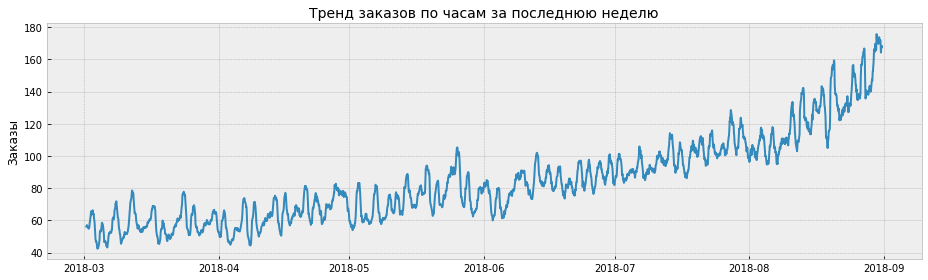

In [24]:
simple_plot(decomposed_data_by_hour.trend[:], title='Тренд заказов по часам за последнюю неделю',
            figsize=(13,4), ylabel='Заказы')

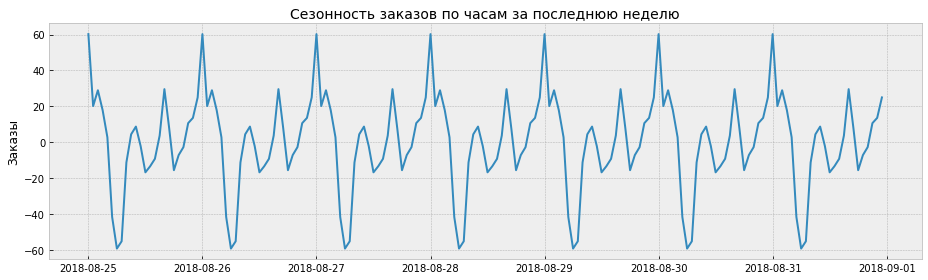

In [25]:
simple_plot(decomposed_data_by_hour.seasonal[-24*7:], title='Сезонность заказов по часам за последнюю неделю',
            figsize=(13, 4), ylabel='Заказы', style='bmh')

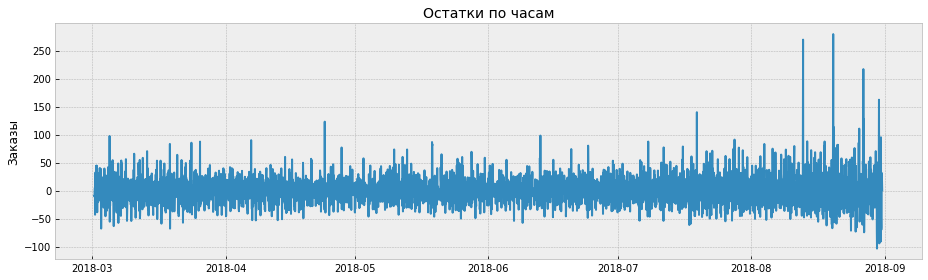

In [26]:
simple_plot(decomposed_data_by_hour.resid, title='Остатки по часам',
            figsize=(13, 4), ylabel='Заказы', style='bmh')

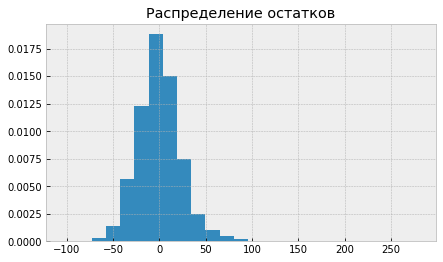

In [27]:
with plt.style.context('bmh'):
    plt.figure(figsize=(7, 4))
    plt.hist(decomposed_data_by_hour.resid.dropna(), bins=25, density=True)
    plt.title('Распределение остатков');

## 2.1. SARIMAX <a id='section2.2'></a>

Т.к. в данных наблюдается сезонность, то будем использовать модель SARIMA

Определим начальное приближение для коэффициентов p, d, q, P, D, Q

Проверим проверим остатки ряда, при помощи встроенных методов 

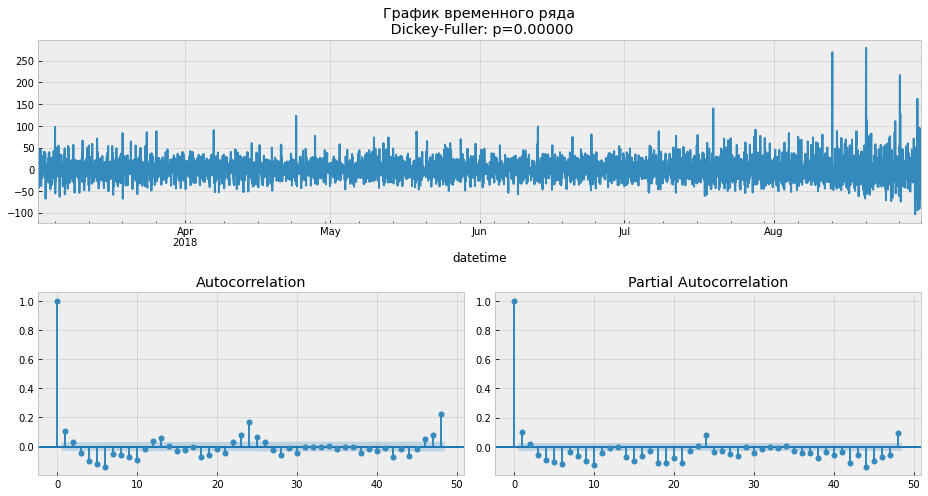

In [28]:
tsplot(decomposed_data_by_hour.resid.dropna(), figsize=(13, 7))

Как видно выше по графикам автокорреляций в остатках еще содержится информация

Проверим тест на стационарность всего ряда при альфа = 0.05

In [29]:
alpha = .05 
print('Нулевая гитотеза - "временной ряд стационарен"')
p_value = sm.tsa.adfuller(data.resample('1H').sum())[1]
print('Вычислим p-value для критеррия Дики-Фуллера:', round(p_value, 5))
if p_value < alpha:
    print('Нулевая гипотеза отвергнута')
else: 
    print('Нулевая гипотеза принята')

Нулевая гитотеза - "временной ряд стационарен"
Вычислим p-value для критеррия Дики-Фуллера: 0.02894
Нулевая гипотеза отвергнута


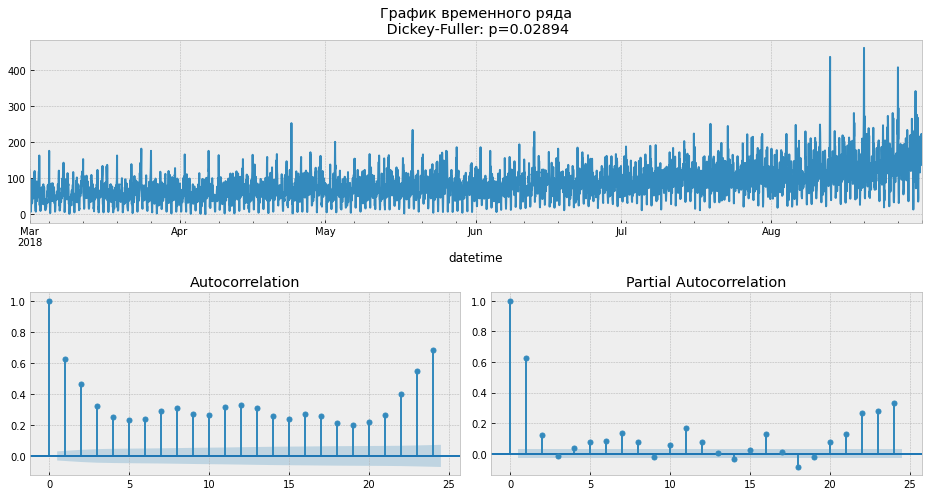

In [30]:
df = data.resample('1H').sum()
tsplot(df.num_orders, lags=24)

Разделим выборку на обучающую и тестовую в соотношении 9:1, данную выборку будем использовать для модели SARIMAX

In [31]:
X, y = train_test_split(df, shuffle=False, test_size=.1)

Так как ряд не стационарен выполним преобразование Бокса-Кокса<br/>
Коэффициент преобразования сохраним в переменной `lmbda_X`

Оптимальный параметр преобразования Бокса-Кокса: 0.605218


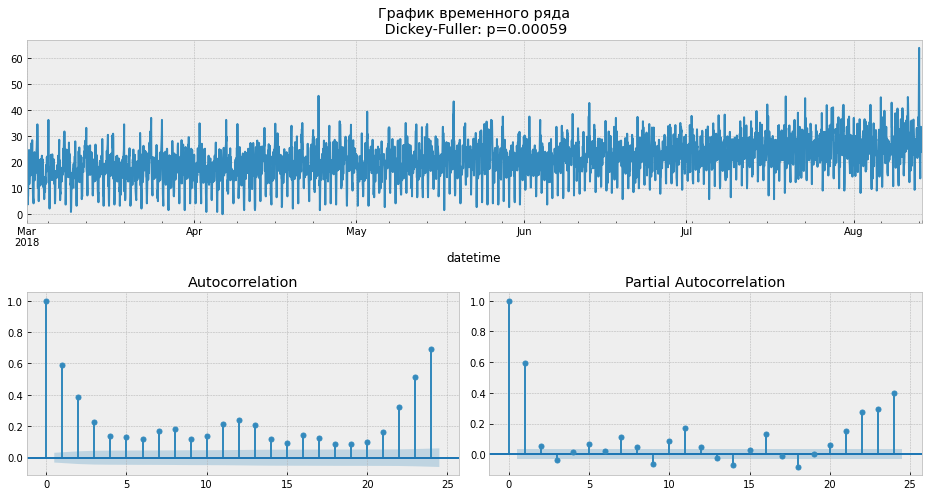

In [32]:
X['orders_box'], lmbda_X = scs.boxcox(X.num_orders+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(X.orders_box, lags=24)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda_X)

Критерий Дики-Фуллера говорит о том, что ряд уже стационарен, однако по графикам автокорреляции еще наблюдаются значимые значения<br/>
Продифференцируем наш ряд, сначала на величину недельной сезонности

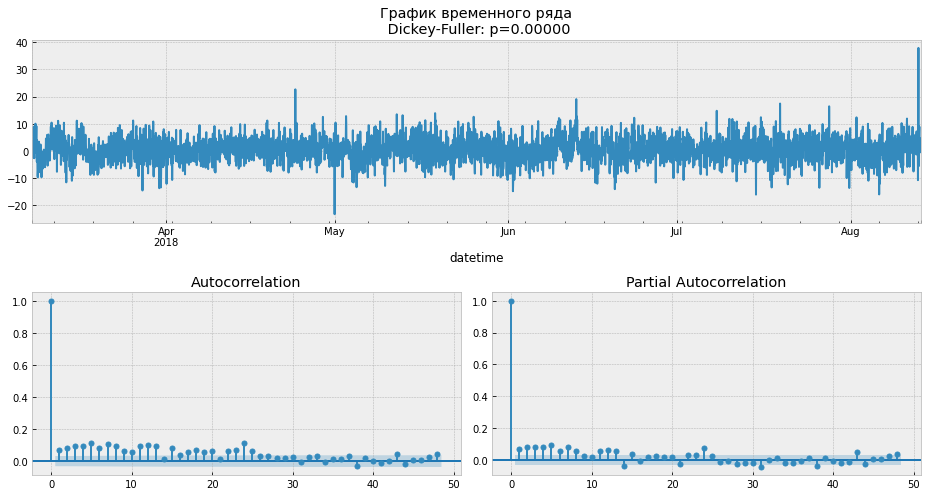

In [33]:
X['orders_box_diff_24x7'] = X.orders_box.diff(24*7)
tsplot(X.orders_box_diff_24x7.dropna(), lags=48)

Теперь еще на 1 значение

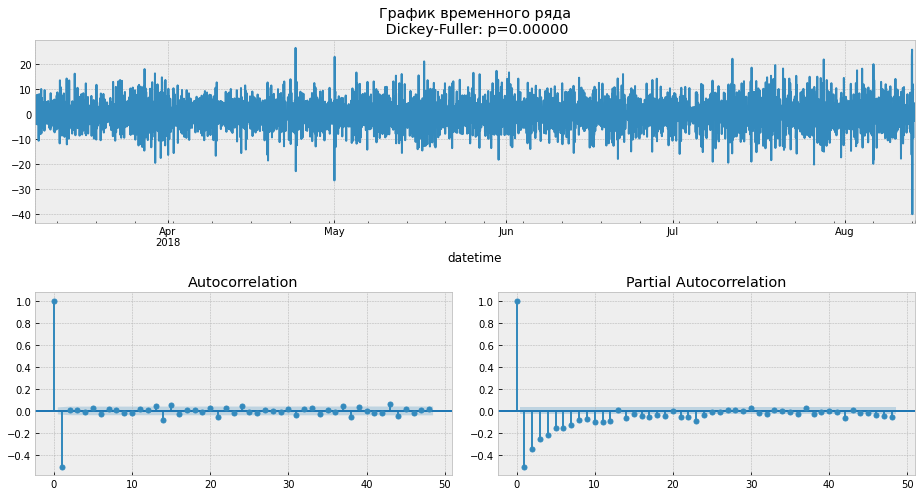

In [34]:
X['orders_box_diff_24x7_diff_1'] = X.orders_box_diff_24x7.diff(1)
tsplot(X.orders_box_diff_24x7_diff_1.dropna(), lags=48)

По графикам автокореляции уже можно сделать заключение о начальном выборе коэффициентов модели

### Вывод

Начальные приближения:
+ P - номер последнего сезонного лага при котором частичная автокорреляция значима (2)<br/>
+ p - номер последнего несезонного лага при котором частичная автокорреляция значима (12)<br/>
+ Q - номер последнего сезонного лага при котором автокорреляция значима (1) <br/>
+ q - номер последнего несезонного лага при котором автокорреляция значима (14)

s - сезон = 24

* [Обучение далее](#section3)

## LinearRegression <a id='section2.3'></a>

Подготовим данные с признаками для линейной модели 

In [35]:
df_lr = df.copy()
df_lr.columns = ['y']

в признаки добавим значения в виде:
* номера часа, дня недели, выходные;
* лаги от 10 до 48 шагов;
* сумма за последние 3, 8, 12 часов и за неделю

In [36]:
X_train, X_test, y_train, y_test = prepareData(df_lr, lag_start=10, lag_end=48,)

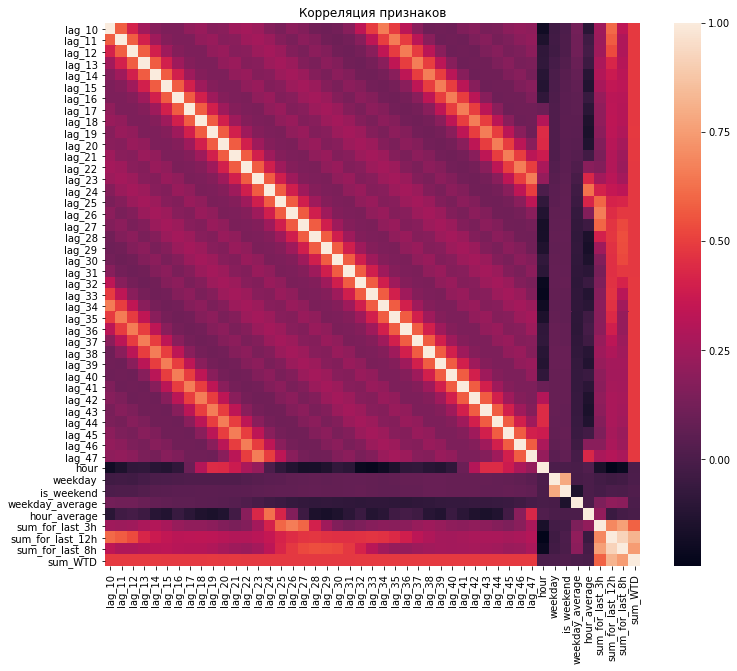

In [37]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr())
plt.title('Корреляция признаков');

Наблюдается корреляция между отдельными признаками, будем иметь это ввиду, в случае необходимости применим регуляризацию

### Вывод 

Произвели feature extraction.
Подготовили начальный стек признаков для линейной регресии

# 3. Обучение <a id='section3'></a>

Для данной модели подбор параметров выполнялся по указанному ниже диапазону лучшую модель выбирали по критерию Акаике, наиболее точный результат удовлетворяющий заданию (RMSE < 48) был достигнут при значениях коэффициентов близких к значениям определенными нами в разделе Анализ. Что говорит о том что мы двигались верно. Можно было продолжить поис лучших коэффициентов для учучшения модели, однако это требует много времени для вычислений

```python
>>>[In]
ps = list(range(0, 4)) + list(range(8, 13, 2))
d=1
qs = list(range(0, 4)) + list(range(10, 15, 2))
Ps = range(0, 3)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)


results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    
    try:
        model = sm.tsa.statespace.SARIMAX(X.orders_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
    except:
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']

result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
print("Лучший AIC:", best_aic)
print(result_table.head())

>>>[Out]
Лучший AIC: 21493.313272017098
    
	parameters	aic
0	(9, 14, 3, 2)	21493.313272
1	(9, 14, 2, 2)	21496.980470
2	(9, 14, 3, 1)	21545.477114
3	(9, 14, 2, 1)	21548.915601
4	(9, 14, 3, 0)	22034.708217
5	(9, 14, 2, 0)	22248.650017
```

Код выше выполнил подбор оптимальных параметров, теперь обучим лучшую модель

```python
>>>[In]
%%time
model_SARIMAX = sm.tsa.statespace.SARIMAX(X.orders_box, order=(9, 1, 14), 
                                            seasonal_order=(3, 1, 2, 24)).fit()

>>>[Out]
CPU times: user 2h 11min 27s, sys: 17.7 s, total: 2h 11min 45s
Wall time: 16min 29s
```

* [Тестирование модели далее](#section4.1)

## LinearRegression


In [38]:
model_lr = LinearRegression()

In [39]:
model_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# 4. Тестирование

## 4.1. SARIMAX <a id='section4.1'></a>

In [40]:
#Загрузим ранее расчитанные предсказания модели по тестовой выборке
SARIMA_y_pred = pd.read_csv('https://my-files.su/Save/w01lwa/SARIMA_model_pred_y.csv',
                            index_col=['Unnamed: 0'], parse_dates=['Unnamed: 0'])
SARIMA_y_pred.index = pd.to_datetime(SARIMA_y_pred.index)

#Загрузим прогноз
SARIMA_y_forecast = pd.read_csv('https://my-files.su/Save/pwzfh4/SARIMA_model_forcast_y.csv',
                            index_col=['Unnamed: 0'], parse_dates=['Unnamed: 0'])
SARIMA_y_forecast.index = pd.to_datetime(SARIMA_y_forecast.index)

In [41]:
#Загрузим для проверки остатки модели
SARIMA_model_resid = pd.read_csv('https://my-files.su/Save/aa9w6g/SARIMA_model_resid.csv',
                            index_col=['datetime'], parse_dates=['datetime'])

In [42]:
#Загрузим ранее расчитанные предсказания модели по тестовой тренировочной
SARIMA_X_pred = pd.read_csv('https://my-files.su/Save/rf0axo/SARIMA_model_pred_X.csv',
                            index_col=['datetime'], parse_dates=['datetime'])

SARIMA_X_forecast = pd.read_csv('https://my-files.su/Save/ykmd00/SARIMA_model_forcast_X.csv',
                            index_col=['Unnamed: 0'], parse_dates=['Unnamed: 0'])
SARIMA_X_forecast.index = pd.to_datetime(SARIMA_X_forecast.index)

In [43]:
SARIMA_mse_wiht_hat = 13.665815642306919

In [44]:
# Проверим остатки в модели
q_test = sm.tsa.stattools.acf(SARIMA_model_resid, qstat=True)
pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}).sort_values(by='p-value').head()

,Q-stat,p-value
37,57.663300,0.021323
38,57.711187,0.027159
39,57.845602,0.033630
35,49.292366,0.068984
36,49.376897,0.083873


Судя по тесту Льюнга — Бокса  только 3 отклоняется гипотеза о том, что остатки не являются случайными, как уже говорилось выше, можно подобрать еще более оптимальные параметры. Но беря во внимание, что качество результата требующегося проектом мы выполнили

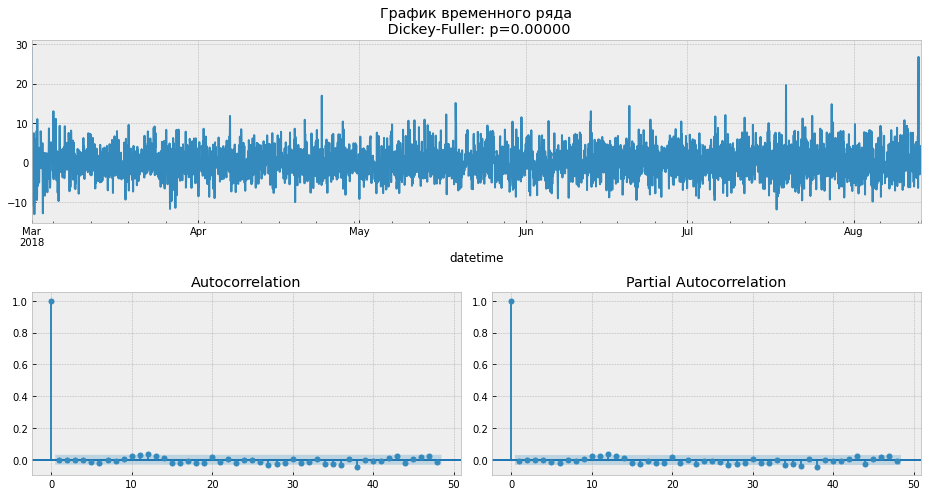

In [45]:
tsplot(SARIMA_model_resid['0'])

По графику тоже заметно, что значимых отличий не наблюдается

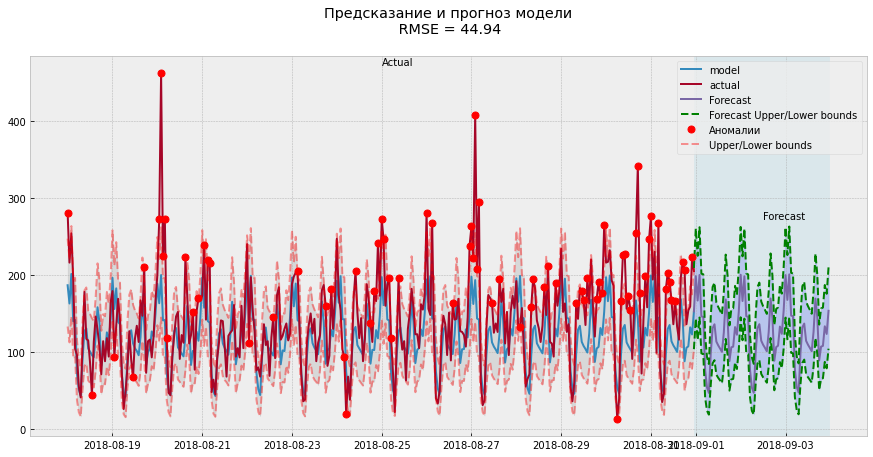

In [46]:
plotSARIXA_result(pred=SARIMA_y_pred, y_true=y, lmbda=lmbda_X, forecast=SARIMA_y_forecast['0'],
                  plot_forecast=True, plot_inervals=True, plot_anomalies=True, forecast_int=24,
                  interval_of_interest=24*7*2 #Результат за последние 2 недели
                 )

Модель все еще плохо улавливает пики, хотя это могли быть аномалии, также стоит отметить что расхождение модели более заметно для более позднего периода, такое чувство, что модель не очень хорошо уловила тренд, хотя в начале рассматриваемого периода предсказания модели достаточно близки.<br/>
Число аномалий после первой недели тестовой выборки значительно увеличиваются, причем если в течение первой недели они восновном связаны с пиками, то для второй недели они уже встречаются не только в пиковые часы

Ощутимые изменения между моделью и фактом наблюдаются на промежутке большем чем 1-на неделя (первую неделю модель предсказала лучше) - как выход может быть обучать модель еженедельно  

Рассмотрим результат на последних 4-х днях выборки

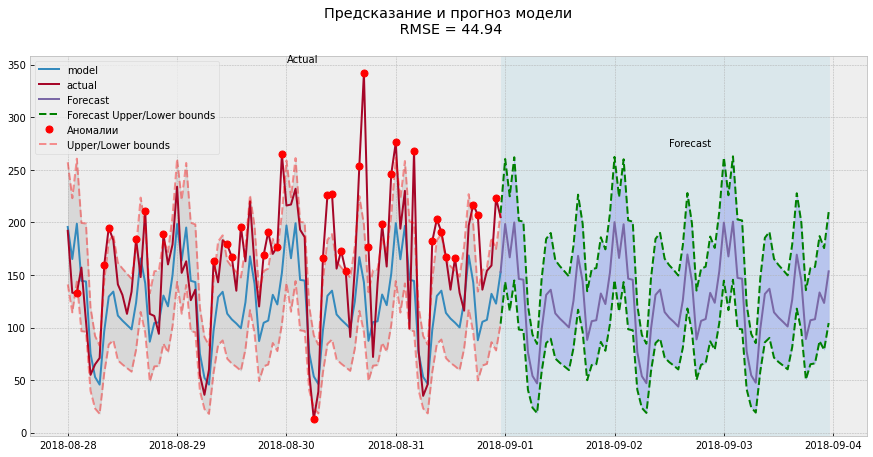

In [47]:
plotSARIXA_result(pred=SARIMA_y_pred, y_true=y, lmbda=lmbda_X, forecast=SARIMA_y_forecast['0'],
                  plot_forecast=True, plot_inervals=True, plot_anomalies=True, forecast_int=24,
                  interval_of_interest=24*4 #Результат за последние 4 дня
                 )

Проверим как модель предсказывает тренировочную выборку

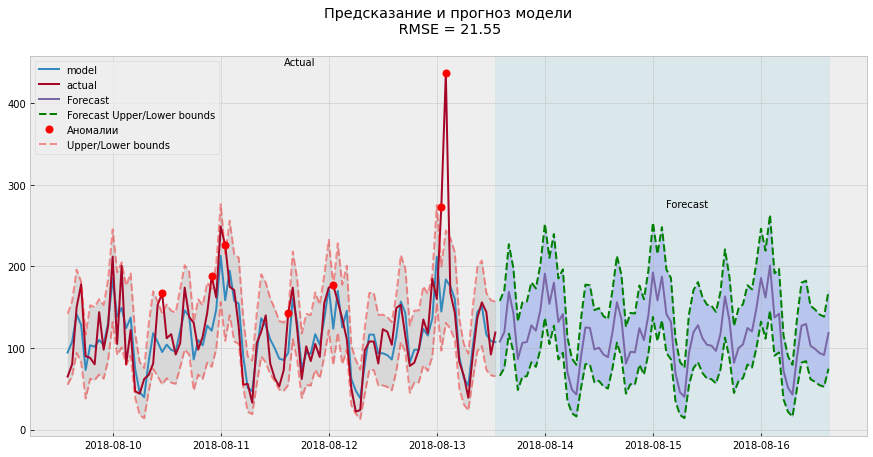

In [48]:
plotSARIXA_result(pred=SARIMA_X_pred, y_true=X.num_orders, lmbda=lmbda_X, forecast=SARIMA_X_forecast['0'],
                  plot_forecast=True, plot_inervals=True, plot_anomalies=True,
                  interval_of_interest=24*4 #Результат за последние 4 дня
                 )

## 4.2. LinearRegression  <a id='section4.2'></a>

In [49]:
pred_lr = model_lr.predict(X_test)

Проверим остатки модели

In [50]:
lin_model_resid = pred_lr - y_test.values
lin_model_resid = pd.DataFrame(lin_model_resid, index=y_test.index)
lin_model_resid.columns = ['resid']

In [51]:
# Проверим остатки в модели
q_test = sm.tsa.stattools.acf(lin_model_resid.resid, qstat=True)
pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}).sort_values(by='p-value').head()

,Q-stat,p-value
0,1.893496,0.168808
9,13.840240,0.180404
10,14.765425,0.193490
28,34.867435,0.208926
11,15.620547,0.209240


Тест Льюнга — Бокса сдан, принимаем гипотезу, что остатки случайны

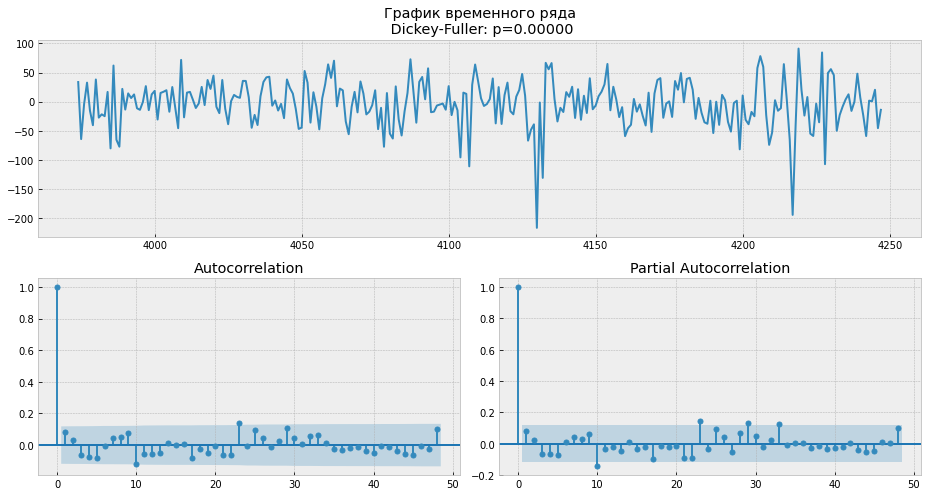

In [52]:
tsplot(lin_model_resid.resid)

Значимых отклонений в остатках не обнаружено, похоже на шум

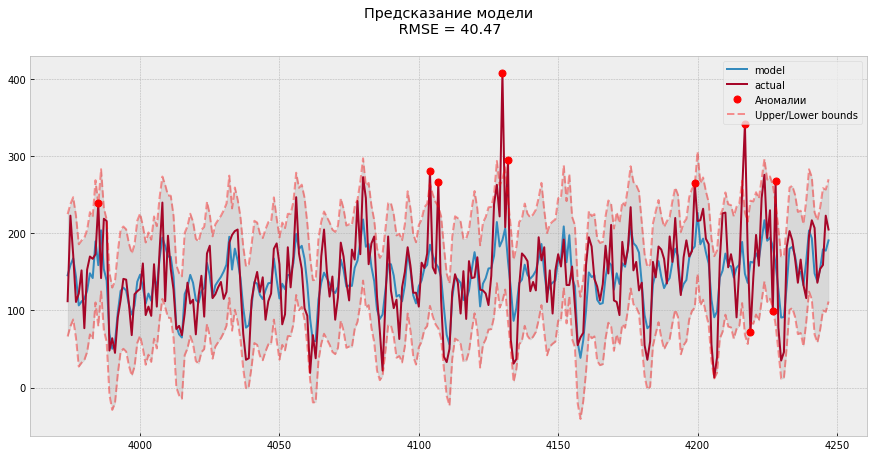

In [53]:
plotLinReg_result(model=model_lr, X_test=X_test, y_test=y_test, interval_of_interest=24*7*2,#Последние 2 недели
                  plot_anomalies=True, plot_inervals=True)

Наблюдается незначительное количество аномалий

## 4.2.1. Улучшим линейную модель и сделаем прогноз <a id='section4.2.1'></a>

Проверим значеия весов признаков модели

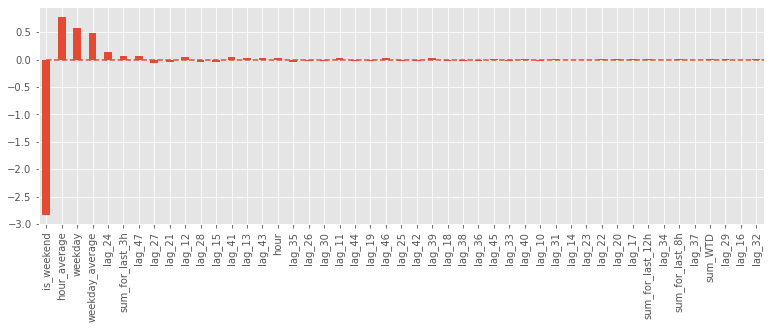

In [54]:
plotCoefficients(model_lr, X_train=X_train)

Применим регуляризацию Лассо

In [55]:
lasso = LassoCV(cv=TimeSeriesSplit(n_splits=5))
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True,
        cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=0.001,
        fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

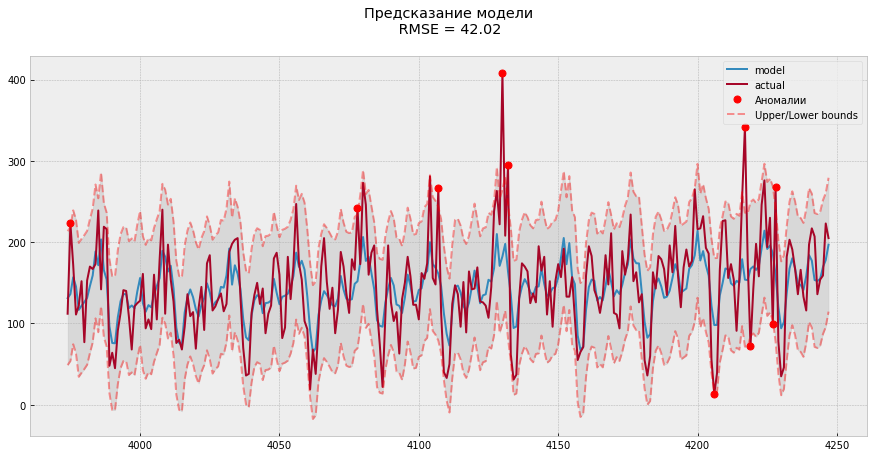

In [56]:
plotLinReg_result(model=lasso, X_test=X_test, y_test=y_test, interval_of_interest=24*7*2,
                  plot_anomalies=True, plot_inervals=True)

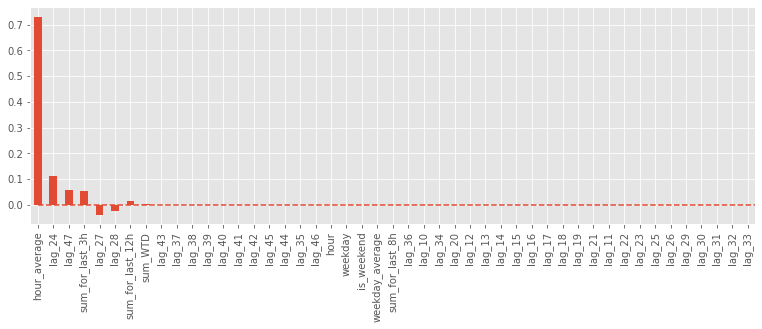

In [57]:
plotCoefficients(lasso, X_train) #Коэффициенты выглядят лучше и уже только необходимые

Извлечем только значимые признаки

In [58]:
coefs = pd.DataFrame(lasso.coef_, X_train.columns)
coefs.columns = ["coef"]
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

In [59]:
best_features = list(coefs.loc[coefs.coef != 0].index)

Обучим линейную модель на новых признаках


In [60]:
lin_model = LinearRegression()
lin_model.fit(X_train[best_features], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

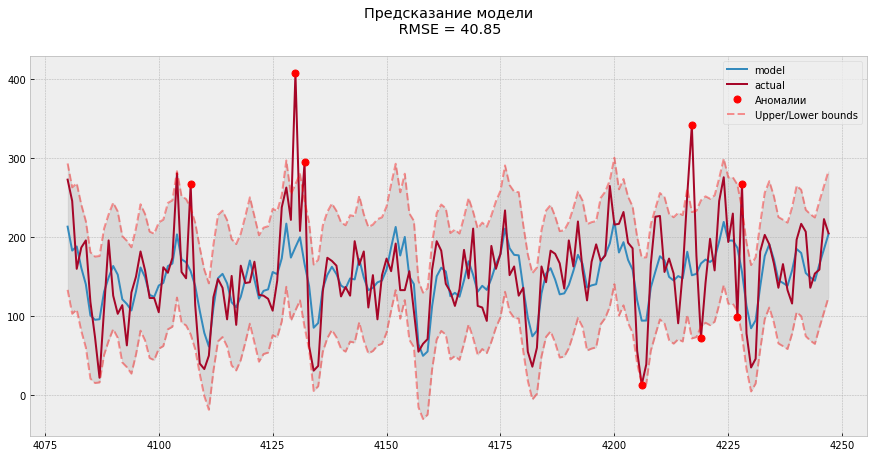

In [61]:
plotLinReg_result(lin_model, X_test[best_features], y_test, plot_inervals=True,
                  plot_anomalies=True, interval_of_interest=24*7)

Качество изменилось незначительно, зато почти в 6 раз сократили количество признаков    

Обучим на всей выборке

In [62]:
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [63]:
lin_model.fit(X_full[best_features], y_full)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

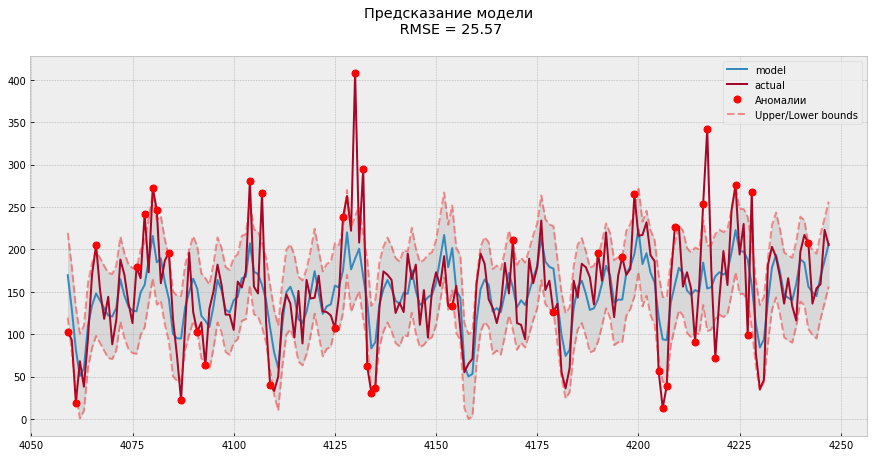

In [64]:
plotLinReg_result(lin_model, X_full[best_features], y_full, plot_inervals=True,
                  plot_anomalies=True, interval_of_interest=27*7)

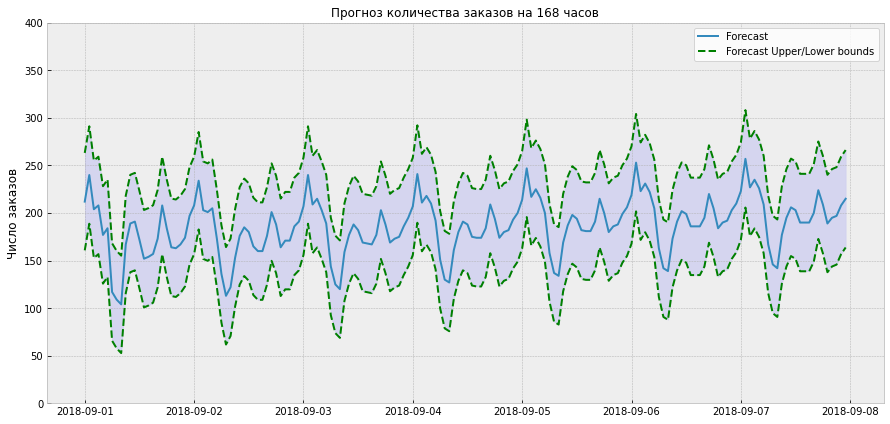

In [65]:
plot_forecast(lin_model, df, steps=24*7)

Сравним последние 6 часов реальных данных и первые 6 часов прогноза

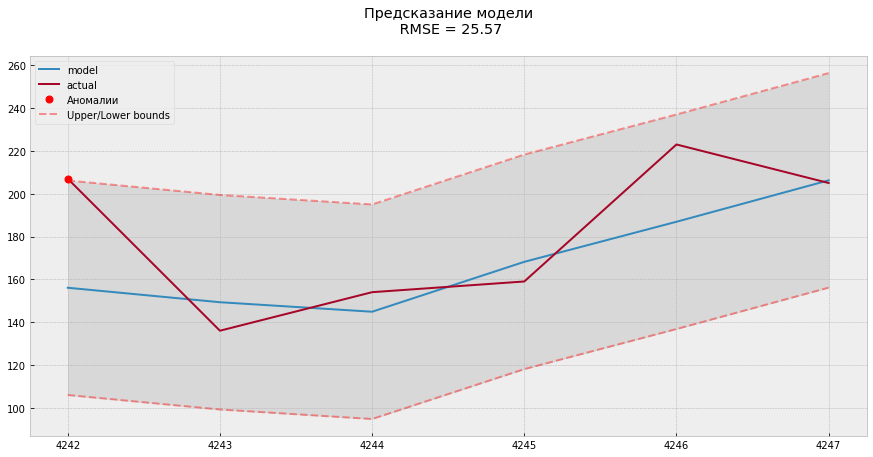

In [66]:
plotLinReg_result(lin_model, X_full[best_features], y_full, plot_inervals=True,
                  plot_anomalies=True, interval_of_interest=6)

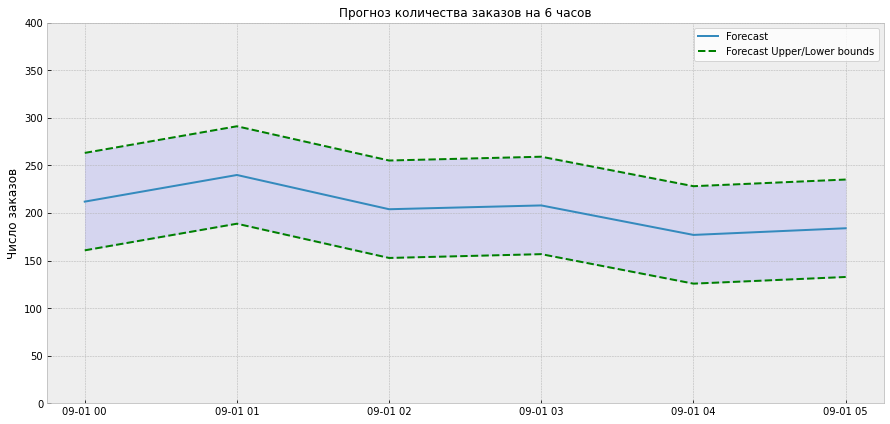

In [67]:
plot_forecast(lin_model, df, steps=6)

Харакрер и границы похожи, т.к. заданием проекта было сделать прогноз на следующий час, то можно считать, что модели справились. 

## Вывод

1. В проекте было опробовано и построено 2-типа моделей - SARIMAX и Линейная регрессия
2. Обе модели показали удовлетворительный результат - RMSE < 48
3. Замечено, что модель SARIMAX несколько отстает от тестовой выборки на реальных данных, первая неделя - ОК далее не успевает за трендом, возможно нужно переобучение либо более тщательный подбор параметров, тем не менее условию качества соответствует.
4. Модель Линейной регреси более уверено и с меньшей ошибкой предсказывает тестовую выборку, однако при построении долгосрочного прогноза проигрывает модели SARIMAX
5. Коротко срочный прогноз Линейной регресии удовлетворяет потребностям и заданию проекта
6. В качестве выбора монкретной модели может служить критерии продолжительности прогноза и скорости обучения. Более быстрообучаемая - Линейная регрессия, более долгосрочные прогнозы - SARIMAX